<a href="https://colab.research.google.com/github/SIDIBEMoussa/Image-segmentation-using-U-Net_/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch > lib
!pip install -U git+https://github.com/albumentations-team/albumentations  > lib
!pip install --upgrade opencv-contrib-python > lib

  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-p_38bfbt


In [2]:
! pip install opencv-python > lib

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


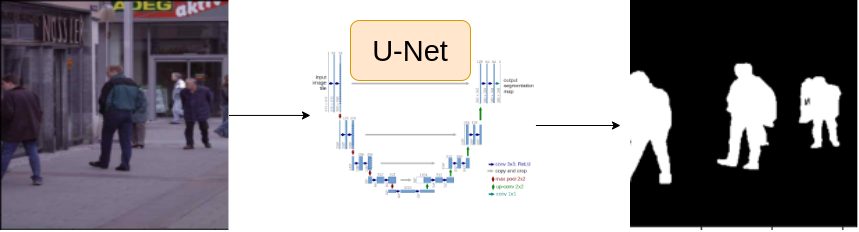

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [6]:
import cv2
print(cv2.__version__)

4.7.0


# Task : 2 Setup Configurations

In [7]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"

DATA_DIR = "/content/"

DEVICE = "cuda"
LR = 0.003
EPOCHS = 25

IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [8]:
df_image = pd.read_csv(CSV_FILE)

df_image.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [9]:
row = df_image.iloc[3]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.


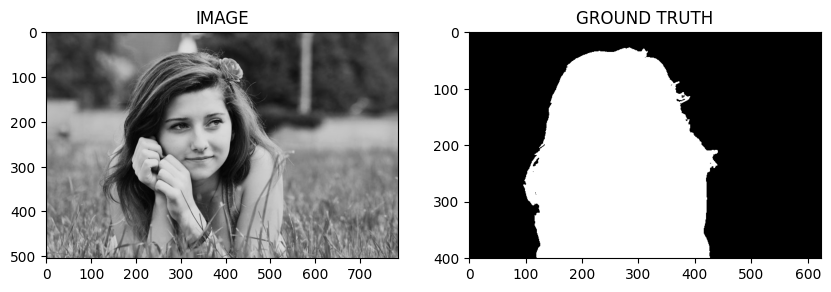

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df_image, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [13]:
def get_train_augs():

  return A.Compose([
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
          A.HorizontalFlip( p = 0.5 ),
          A.VerticalFlip( p = 0.5 )
      ])

def get_valid_augs():

  return A.Compose([
          A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      ])

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [15]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations

    def __len__(self):

        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
        mask = np.expand_dims(mask, axis =-1)

        if self.augmentations:

            data = self.augmentations(image = image, mask = mask)

            image = data["image"]
            mask = data["mask"]

          #(h,w,c) ---> (c,w,h)

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image =torch.Tensor(image)/255.0
        mask = torch.round(torch.Tensor(image)/255.0)

        return image, mask

In [16]:
trainset = SegmentationDataset(train_df, get_train_augs())

validset = SegmentationDataset(valid_df, get_valid_augs())

In [17]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


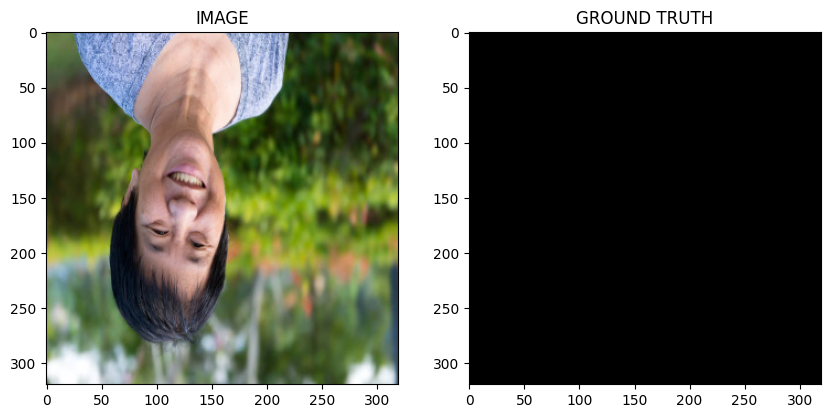

# Task 5 : Load dataset into batches

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

# Task 7 : Create Train and Validation Function

# Task 8 : Train Model

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya